RAIN - Real & Artificial Intelligence for Neuroscience

## Create models
- This notebook will create and train Artificial Neural Networks to identify exploration using rodent and target position along with manually labeled data.

#### Requirements:

- A set of position files
- Labeled data for those position files (to train the model)

or

- Access to the example file **colabels.csv**, where we can find:
    - Position and labels for representative exploration events
    - Manual labels from 5 viewers (so far)

---
#### Load the necessary modules

In [2]:
from pathlib import Path
import rainstorm.old_modeling as rst

rainstorm.modeling successfully imported. GPU devices detected: []


---
#### 1. State your models project path
`base` : The path to the downloaded repository.

`models_folder` : The path to the folder containing the files you'll use to create the models.

In [3]:
base = Path(r'c:\Users\dhers\Desktop\Rainstorm')
models_folder = base / r'examples\models'

---
#### Create the colabels file

The Colabels file is a csv file that contains both mice positions, exploration target positions, and one or more sets of labels for the behavior you want to analyze.

If you want to train the models using your own colabels file, you can create it using the create_colabels function below. 

All you need is:
- A folder containing the positions of the mice
- A folder for each labeler, containing the labels for the behavior you want to analyze
- A list of the targets (stationary points) present on your videos


```python
path = r'path/to/colabels_folder' # The path to the directory containing the positions folder and labelers folders
labelers = ['labeler_A', 'labeler_B', 'etc']
targets = ['tgt_1', 'tgt_2', 'etc']

rst.create_colabels(path, labelers, targets)
```

##### There is a Colabels file available in the models folder which contains positions and labels for mice on a novel object recognition task. If you want to analyze the demo data, train the models using that colabels file.

---
#### 2.  Create the modeling.yaml file

The modeling.yaml file is a configuration file that contains all the parameters needed to create and train the models. It will be located in the models folder.

In [4]:
modeling = rst.create_modeling(models_folder)

INFO:rainstorm.old_modeling:✅ modeling.yaml already exists: c:\Users\dhers\Desktop\Rainstorm\examples\models\modeling.yaml
Skipping creation.



It contains the following parameters:

`path` : Path to the models folder

`colabels` : The colabels file is used to store and organize positions and labels for model training
- colabels_path: Path to the colabels folder
- labelers: List of labelers on the colabels file (as found in the columns)
- target: Name of the target on the colabels file

`focus_distance`: Window of frames to consider around an exploration event

`bodyparts`: List of bodyparts used to train the model

`split`: Parameters for splitting the data into training, validation, and testing sets
- validation: Percentage of the data to use for validation
- test: Percentage of the data to use for testing

`RNN`: Set up the Recurrent Neural Network
- width: Defines the shape of the wide model
  - past : Number of past frames to include
  - future : Number of future frames to include
  - broad : Broaden the window by skipping some frames as we stray further from the present
- units: Number of neurons on each layer
- batch_size: Number of training samples the model processes before updating its weights
- epochs: Each epoch is a complete pass through the entire training dataset
- lr: Learning rate


---
#### 3. Before training a model, we need to prepare our training data
- First, we load the dataset from the colabels file and create one 'labels' column out of all the labelers.
- Next (optional, but recommended) we can erase the rows of the dataset that are too far away from exploration events.
- Finally, we split the dataset into training, testing and validation subsets.

In [5]:
# Prepare the data
dataset = rst.prepare_data(modeling)

# Focus on the rows near exploratory behaviour
dataset = rst.focus(modeling, dataset)

# Split the data
model_dict = rst.split_tr_ts_val(modeling, dataset)

# Save the split
rst.save_split(modeling, model_dict)

INFO:rainstorm.utils:Successfully loaded YAML file: 'c:\Users\dhers\Desktop\Rainstorm\examples\models\modeling.yaml'
INFO:rainstorm.old_modeling:🧹 Smoothing column: labels
INFO:rainstorm.utils:Successfully loaded YAML file: 'c:\Users\dhers\Desktop\Rainstorm\examples\models\modeling.yaml'
INFO:rainstorm.old_modeling:🔍 Focusing based on 'labels', with distance ±30 frames
INFO:rainstorm.old_modeling:  ▶ Original rows: 167012
INFO:rainstorm.old_modeling:  ▶ Found 10231 event rows
INFO:rainstorm.old_modeling:  ✅ Filtered rows: 38161
INFO:rainstorm.utils:Successfully loaded YAML file: 'c:\Users\dhers\Desktop\Rainstorm\examples\models\modeling.yaml'
INFO:rainstorm.old_modeling:Training set:    26770 samples
INFO:rainstorm.old_modeling:Validation set:  5417 samples
INFO:rainstorm.old_modeling:Testing set:     5974 samples
INFO:rainstorm.old_modeling:Total samples:   38161
INFO:rainstorm.utils:Successfully loaded YAML file: 'c:\Users\dhers\Desktop\Rainstorm\examples\models\modeling.yaml'
INFO:r

---
If you later want to load a previous split, run:

```python
saved_split = models_folder / 'splits/split_{example_date}.h5' # Select the split you want to rescue
model_dict = rst.load_split(saved_split)
```

---
We can see on the testing data that the exploratory events happen when the nose gets close to the object

In [6]:
rst.plot_example_data(model_dict['X_ts'], model_dict['y_ts'])

---
#### 4. With the training data ready, we can use TensorFlow to design your very first model
- It will look at the positions of one frame at a time, and try to decide if the mouse is exploring.
- If the decision is correct the architecture will be reinforced, else it will be corrected according to the learning rate.
- We will train it for some epochs (cycles through the whole dataset) and plot how the accuracy and loss evolve.
- Also, we will be validating the training using the validation split, which contains frames that were not used for training.

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
import datetime
time = datetime.datetime.now()

# Build a simple neural network
model_simple = tf.keras.Sequential([
    
    # Input layer
    Input(shape=(model_dict['X_tr'].shape[1],)), 

    # Hidden layers
    Dense(32, activation='relu'),
    Dense(24, activation='relu'),
    Dense(16, activation='relu'),
    Dense(12, activation='relu'),
    Dense(8, activation='relu'),
    
    # Output layer
    Dense(1, activation='sigmoid')
])

# Compile the model
model_simple.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), 
                   loss='binary_crossentropy', metrics=['accuracy'])

model_simple.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                416       
                                                                 
 dense_1 (Dense)             (None, 24)                792       
                                                                 
 dense_2 (Dense)             (None, 16)                400       
                                                                 
 dense_3 (Dense)             (None, 12)                204       
                                                                 
 dense_4 (Dense)             (None, 8)                 104       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,925
Trainable params: 1,925
Non-trainabl

#### Train the model
Each ``epoch`` is a complete pass through the entire training dataset, while the ``batch_size`` is the number of training samples the model processes before updating its weights

In [8]:
history_simple = model_simple.fit(model_dict['X_tr'], model_dict['y_tr'],
                                  epochs=10, batch_size=128,
                                  validation_data=(model_dict['X_val'], model_dict['y_val']))

Epoch 1/10
210/210 [==============================] - 1s 2ms/step - loss: 0.5038 - accuracy: 0.6678 - val_loss: 0.4239 - val_accuracy: 0.6812
Epoch 2/10
210/210 [==============================] - 0s 1ms/step - loss: 0.4147 - accuracy: 0.6700 - val_loss: 0.3759 - val_accuracy: 0.6786
Epoch 3/10
210/210 [==============================] - 0s 947us/step - loss: 0.3740 - accuracy: 0.6844 - val_loss: 0.3356 - val_accuracy: 0.6891
Epoch 4/10
210/210 [==============================] - 0s 1ms/step - loss: 0.3323 - accuracy: 0.7248 - val_loss: 0.2984 - val_accuracy: 0.7362
Epoch 5/10
210/210 [==============================] - 0s 1ms/step - loss: 0.2927 - accuracy: 0.7658 - val_loss: 0.2678 - val_accuracy: 0.7637
Epoch 6/10
210/210 [==============================] - 0s 1ms/step - loss: 0.2599 - accuracy: 0.7833 - val_loss: 0.2475 - val_accuracy: 0.7672
Epoch 7/10
210/210 [==============================] - 0s 944us/step - loss: 0.2408 - accuracy: 0.7887 - val_loss: 0.2385 - val_accuracy: 0.7683
Ep

#### Plot the training and validation loss

In [9]:
rst.plot_history(history_simple, "Simple")

#### Calculate accuracy and precision of the model

In [10]:
y_pred_simple = model_simple.predict(model_dict['X_ts'])
accuracy_simple, precision_simple, recall_simple, f1_simple, mse_simple, mae_simple, r2_simple = rst.evaluate(y_pred_simple, model_dict['y_ts'], show_report = True)
print(f"Accuracy = {accuracy_simple:.4f}, Precision = {precision_simple:.4f}, Recall = {recall_simple:.4f}, F1 Score = {f1_simple:.4f}, MSE = {mse_simple:.4f}, MAE = {mae_simple:.4f}, R-squared = {r2_simple:.4f} -> simple")

187/187 [==============================] - 0s 616us/step
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      4570
           1       0.81      0.88      0.85      1404

    accuracy                           0.93      5974
   macro avg       0.89      0.91      0.90      5974
weighted avg       0.93      0.93      0.93      5974

Accuracy = 0.9250, Precision = 0.9281, Recall = 0.9250, F1 Score = 0.9261, MSE = 0.0413, MAE = 0.1129, R-squared = 0.7428 -> simple


#### And finally, save the model

In [11]:
model_name = f'{time.date()}_simple'
rst.save_model(modeling, model_simple, model_name)

INFO:rainstorm.utils:Successfully loaded YAML file: 'c:\Users\dhers\Desktop\Rainstorm\examples\models\modeling.yaml'


---
#### 5. Now that we have a simple model trained, we can start building more complex models

To make our artificial networks as real as possible, we can let them see a sequence of frames to decide if the mouse is exploring
- Our build_RNN function will use Bidirectional LSTM layers that allow the model to take into account the temporal sequence of frames
- It also implements early stopping and learning rate scheduler mechanisms that will prevent the model from overfitting

We can control the RNN model by changing the following parameters on the modeling.yaml file:

`units` : The number of neurons on each layer of the LSTM model

`batch_size` : The number of training samples the model processes before updating its weights

`lr` : The learning rate of the model

`epochs` : The number of times the model will be trained on the entire training dataset

`past` & `future` : If you use a LSTM model, you can set the window size by saying how many frames into the past and how many into the future you want to see.

`broad` : Once you have your window size, we can broaden the window by skipping some frames as it strays further from the present.

In [12]:
model_wide = rst.build_RNN(modeling, model_dict)

INFO:rainstorm.utils:Successfully loaded YAML file: 'c:\Users\dhers\Desktop\Rainstorm\examples\models\modeling.yaml'


[1, 1, 1, 1, 1, 0]
Model: "ModularBidirectionalRNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_sequence (InputLayer)    [(None, 7, 12)]      0           []                               
                                                                                                  
 bilstm_0 (Bidirectional)       (None, 7, 32)        3712        ['input_sequence[0][0]']         
                                                                                                  
 bn_0 (BatchNormalization)      (None, 7, 32)        128         ['bilstm_0[0][0]']               
                                                                                                  
 dropout_0 (Dropout)            (None, 7, 32)        0           ['bn_0[0][0]']                   
                                                         

#### Train the model

In [13]:
history_wide = rst.train_RNN(modeling, model_dict, model_wide)

INFO:rainstorm.utils:Successfully loaded YAML file: 'c:\Users\dhers\Desktop\Rainstorm\examples\models\modeling.yaml'



Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/100
419/419 - 23s - loss: 1.0661 - accuracy: 0.4281 - val_loss: 0.7390 - val_accuracy: 0.4853 - lr: 1.0000e-05 - 23s/epoch - 54ms/step

Epoch 2: LearningRateScheduler setting learning rate to 1.2589254117941673e-05.
Epoch 2/100
419/419 - 9s - loss: 0.8612 - accuracy: 0.4832 - val_loss: 0.6637 - val_accuracy: 0.5390 - lr: 1.2589e-05 - 9s/epoch - 22ms/step

Epoch 3: LearningRateScheduler setting learning rate to 1.5848931924611138e-05.
Epoch 3/100
419/419 - 9s - loss: 0.7384 - accuracy: 0.5344 - val_loss: 0.5401 - val_accuracy: 0.6121 - lr: 1.5849e-05 - 9s/epoch - 22ms/step

Epoch 4: LearningRateScheduler setting learning rate to 1.9952623149688796e-05.
Epoch 4/100
419/419 - 9s - loss: 0.6468 - accuracy: 0.5803 - val_loss: 0.4722 - val_accuracy: 0.6583 - lr: 1.9953e-05 - 9s/epoch - 22ms/step

Epoch 5: LearningRateScheduler setting learning rate to 2.5118864315095805e-05.
Epoch 5/100
419/419 - 9s - loss: 0.5651 - accu

#### Plot the training and validation loss

In [14]:
rst.plot_history(history_wide, "wide")

#### Calculate accuracy and precision of the model

In [15]:
y_pred_wide = model_wide.predict(model_dict['X_ts_wide'])
accuracy_wide, precision_wide, recall_wide, f1_wide, mse_wide, mae_wide, r2_wide = rst.evaluate(y_pred_wide, model_dict['y_ts'], show_report=True)
print(f"Accuracy = {accuracy_wide:.4f}, Precision = {precision_wide:.4f}, Recall = {recall_wide:.4f}, F1 Score = {f1_wide:.4f}, MSE = {mse_wide:.4f}, MAE = {mae_wide:.4f}, R-squared = {r2_wide:.4f} -> wide")

187/187 [==============================] - 3s 5ms/step
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      4570
           1       0.75      0.91      0.82      1404

    accuracy                           0.91      5974
   macro avg       0.86      0.91      0.88      5974
weighted avg       0.92      0.91      0.91      5974

Accuracy = 0.9078, Precision = 0.9186, Recall = 0.9078, F1 Score = 0.9106, MSE = 0.0472, MAE = 0.0975, R-squared = 0.7059 -> wide


#### Save the wide model

In [16]:
model_name = f'{time.date()}_wide'
rst.save_model(modeling, model_wide, model_name)

INFO:rainstorm.utils:Successfully loaded YAML file: 'c:\Users\dhers\Desktop\Rainstorm\examples\models\modeling.yaml'


---
#### 6. Finally, compare the trained models

- Since we trained using the training dataset, and validated using the validation dataset... we test each model using the testing dataset.

In [17]:
# Print the model results
print("Evaluate model vs testing data")

print("VS binary average")
print(f"Accuracy = {accuracy_simple:.4f}, Precision = {precision_simple:.4f}, Recall = {recall_simple:.4f}, F1 Score = {f1_simple:.4f} -> simple")
print(f"Accuracy = {accuracy_wide:.4f}, Precision = {precision_wide:.4f}, Recall = {recall_wide:.4f}, F1 Score = {f1_wide:.4f} -> wide")

print("VS continuous average")
print(f"MSE = {mse_simple:.4f}, MAE = {mae_simple:.4f}, R-squared = {r2_simple:.4f} -> simple")
print(f"MSE = {mse_wide:.4f}, MAE = {mae_wide:.4f}, R-squared = {r2_wide:.4f} -> wide")

Evaluate model vs testing data
VS binary average
Accuracy = 0.9250, Precision = 0.9281, Recall = 0.9250, F1 Score = 0.9261 -> simple
Accuracy = 0.9078, Precision = 0.9186, Recall = 0.9078, F1 Score = 0.9106 -> wide
VS continuous average
MSE = 0.0413, MAE = 0.1129, R-squared = 0.7428 -> simple
MSE = 0.0472, MAE = 0.0975, R-squared = 0.7059 -> wide


---
---
#### Our trained models are stored safely in our repository, with today's date.
We can:
- Continue on this notebook and evaluate the trained models.
- Skip the evaluation and go use the models on our data in `3b-Automatic_analysis`.
---


## Evaluate models

I see you've decided to continue on this notebook! You wont regret it.

One may think that the evaluation we did on the testing set is enough, and in many cases it is. However, for our purpose of finding a model that resembles the labeling of an expert, It's better to compare the performance of the model against all the manually labeled data we have.

In [24]:
evaluation_dict = rst.build_evaluation_dict(modeling)

INFO:rainstorm.utils:Successfully loaded YAML file: 'c:\Users\dhers\Desktop\Rainstorm\examples\models\modeling.yaml'


---
#### 7. Calculate a good reference labeler
Since we want to compare the models and the labelers, we need to create a reference labeler.

This reference could be the mean of all the labelers, but then the labelers would have an unfair advantage.

To avoid this, we choose to simultaneously create a chimera labeler and a leave-one-out-mean:
- The chimera is created by randomly selecting a labeler on each row of the data.
- The leave-one-out-mean is created by averaging the remaining labelers.

This way, we can compare the chimera to the leave-one-out-mean knowing that they are independent.

In [25]:
# Create the chimera and the leave-one-out mean
evaluation_dict['chimera'], evaluation_dict['loo_mean'] = rst.create_chimera_and_loo_mean(evaluation_dict['manual_labels'], seed=42)

---
#### 8. Load the models & use them to label exploration on all the available data

In [ ]:
# List the models you want to evaluate
model_paths = {
    'example_simple': models_folder / 'trained_models/example_simple.keras',
    'example_wide': models_folder / 'trained_models/example_wide.keras',
    f'{time.date()}_simple': models_folder / f'trained_models/{time.date()}_simple.keras',
    f'{time.date()}_wide': models_folder / f'trained_models/{time.date()}_wide.keras',
    # Add more models as needed...
    }

In [27]:
models_dict = rst.build_and_run_models(modeling, model_paths, evaluation_dict['position'])

INFO:rainstorm.utils:Successfully loaded YAML file: 'c:\Users\dhers\Desktop\Rainstorm\examples\models\modeling.yaml'


Loading model from: c:\Users\dhers\Desktop\Rainstorm\examples\models\trained_models\example_simple.keras
5220/5220 [==============================] - 3s 552us/step
Loading model from: c:\Users\dhers\Desktop\Rainstorm\examples\models\trained_models\example_wide.keras


c:\Users\dhers\miniconda3\envs\rainstorm\lib\site-packages\keras\layers\core\lambda_layer.py:327: UserWarning:

rainstorm.modeling is not loaded, but a Lambda layer uses it. It may cause errors.



5220/5220 [==============================] - 14s 2ms/step
Loading model from: c:\Users\dhers\Desktop\Rainstorm\examples\models\trained_models\2025-06-07_simple.keras
5220/5220 [==============================] - 3s 571us/step
Loading model from: c:\Users\dhers\Desktop\Rainstorm\examples\models\trained_models\2025-06-07_wide.keras
5220/5220 [==============================] - 31s 5ms/step
Loading model from: c:\Users\dhers\Desktop\Rainstorm\examples\models\trained_models\gemini_model.keras


c:\Users\dhers\miniconda3\envs\rainstorm\lib\site-packages\keras\layers\core\lambda_layer.py:327: UserWarning:

rainstorm.modeling.model_building is not loaded, but a Lambda layer uses it. It may cause errors.



5220/5220 [==============================] - 36s 6ms/step


In [29]:
evaluation_dict.update(models_dict)
evaluation_dict = {k: v for k, v in evaluation_dict.items() if k not in {'position', 'manual_labels'}}
print(evaluation_dict.keys())  # Check the keys to confirm the additions

dict_keys(['Labeler_A', 'Labeler_B', 'Labeler_C', 'Labeler_D', 'Labeler_E', 'geometric', 'chimera', 'loo_mean', 'model_example_simple', 'model_example_wide', 'model_2025-06-07_simple', 'model_2025-06-07_wide', 'model_example_gemini'])


---
#### 9. With all the labels organized, we can evaulate the performance of each

In [30]:
for name, pred in evaluation_dict.items():
    accuracy, precision, recall, f1, mse, mae, r2 = rst.evaluate(pred, evaluation_dict['loo_mean'])
    print(f"Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, MSE = {mse:.4f}, MAE = {mae:.4f}, R-squared = {r2:.4f} -> {name}")

Accuracy = 0.9769, Precision = 0.9834, Recall = 0.9769, F1 Score = 0.9787, MSE = 0.0114, MAE = 0.0225, R-squared = 0.7654 -> Labeler_A
Accuracy = 0.9826, Precision = 0.9825, Recall = 0.9826, F1 Score = 0.9813, MSE = 0.0157, MAE = 0.0268, R-squared = 0.6769 -> Labeler_B
Accuracy = 0.9648, Precision = 0.9780, Recall = 0.9648, F1 Score = 0.9687, MSE = 0.0183, MAE = 0.0294, R-squared = 0.6237 -> Labeler_C
Accuracy = 0.9902, Precision = 0.9908, Recall = 0.9902, F1 Score = 0.9904, MSE = 0.0086, MAE = 0.0197, R-squared = 0.8244 -> Labeler_D
Accuracy = 0.9928, Precision = 0.9927, Recall = 0.9928, F1 Score = 0.9927, MSE = 0.0087, MAE = 0.0198, R-squared = 0.8207 -> Labeler_E
Accuracy = 0.9759, Precision = 0.9744, Recall = 0.9759, F1 Score = 0.9744, MSE = 0.0222, MAE = 0.0333, R-squared = 0.5449 -> geometric
Accuracy = 0.9766, Precision = 0.9788, Recall = 0.9766, F1 Score = 0.9775, MSE = 0.0183, MAE = 0.0294, R-squared = 0.6239 -> chimera
Accuracy = 1.0000, Precision = 1.0000, Recall = 1.0000, F

We can visualize the similarity between labelers using a cosine similarity plot

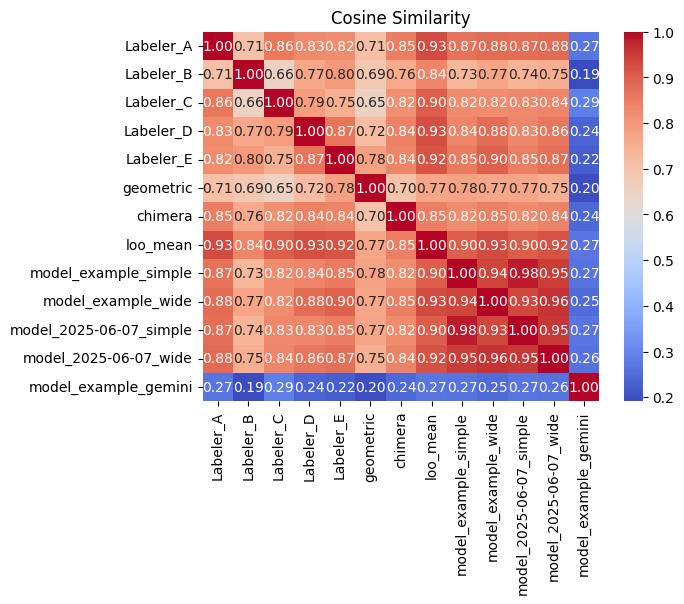

In [31]:
cosine_sim = rst.calculate_cosine_sim(evaluation_dict)

And finally, run a PCA (Principal Components Analysis) to see how much each labeler resembles eachother and the mean

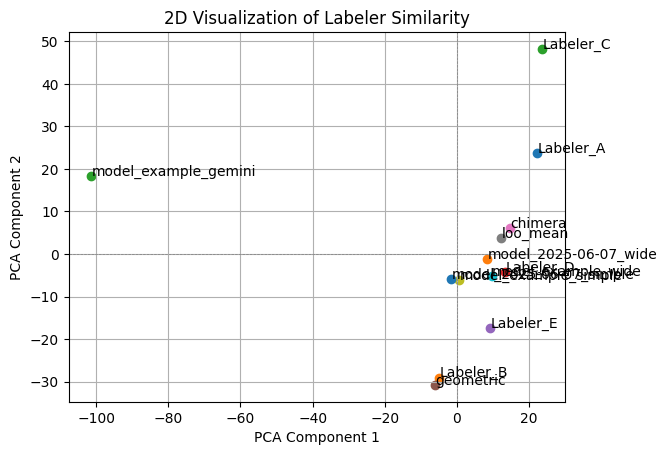

In [32]:
rst.plot_PCA(evaluation_dict)

Also, we can see both the models and the labelers performance on an example video

In [35]:
example_folder_path = base / r'examples\colabeled_video'

labelers_example = {
    "labeler_A": "Example_labeler_A.csv",
    "labeler_B": "Example_labeler_B.csv",
    "labeler_C": "Example_labeler_C.csv",
    "labeler_D": "Example_labeler_D.csv",
    "labeler_E": "Example_labeler_E.csv"
}

rst.plot_performance_on_video(example_folder_path, model_paths, labelers_example, fps = 25, 
                              bodyparts = ['nose', 'left_ear', 'right_ear', 'head', 'neck', 'body'], 
                              targets = ['obj_1', 'obj_2'], plot_tgt = "obj_2")

Loading model from: c:\Users\dhers\Desktop\Rainstorm\examples\models\trained_models\example_simple.keras
469/469 [==============================] - 0s 617us/step
Loading model from: c:\Users\dhers\Desktop\Rainstorm\examples\models\trained_models\example_wide.keras


c:\Users\dhers\miniconda3\envs\rainstorm\lib\site-packages\keras\layers\core\lambda_layer.py:327: UserWarning:

rainstorm.modeling is not loaded, but a Lambda layer uses it. It may cause errors.



469/469 [==============================] - 2s 2ms/step
Loading model from: c:\Users\dhers\Desktop\Rainstorm\examples\models\trained_models\2025-06-07_simple.keras
469/469 [==============================] - 0s 496us/step
Loading model from: c:\Users\dhers\Desktop\Rainstorm\examples\models\trained_models\2025-06-07_wide.keras
469/469 [==============================] - 6s 6ms/step
Loading model from: c:\Users\dhers\Desktop\Rainstorm\examples\models\trained_models\gemini_model.keras


c:\Users\dhers\miniconda3\envs\rainstorm\lib\site-packages\keras\layers\core\lambda_layer.py:327: UserWarning:

rainstorm.modeling.model_building is not loaded, but a Lambda layer uses it. It may cause errors.



469/469 [==============================] - 5s 6ms/step


---
---
#### Once we get to this point, we should have selected our favorite model.
We can move on to the next notebook, `3b-Automatic_analysis`, and use the chosen model to label our position files.

---
RAINSTORM - Created on Dec 12, 2023 - @author: Santiago D'hers